In [70]:
import numpy
from matplotlib import pyplot, cm, rcParams
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
rcParams['font.size'] = 14

In [344]:
# Space Discretizations
Lx = 8                      # length in x direction (horizontal)
Ly = 2                      # length in y direction (vertical)
nx = 51                     # number of discretizations in x
ny = 51                     # number of discretizations in y
dx = Lx/(nx-1)               # spatial increment in x
dy = Ly/(ny-1)               # spatial increment in y
x = numpy.linspace(0,Lx,nx) # array for plotting in x
y = numpy.linspace(0,Ly,ny) # array for plotting in y
X,Y = numpy.meshgrid(x,y)   # mesh grid for plotting

sigma = 1.0
c = 1

# time discretization
time = 1       # total time in seconds
nt = 501        # number of time steps
dt = sigma*dx/c # time increment

In [339]:
def init_cond(ny,nx,Lx,Ly,X,Y):
    """Creates initial conditions for 2D wave, a Guassian function centered on
        the top edge of the box and spread out over the middle.
    
    Parameters:
    -----------
    ny: int
        number of spatial steps in vertical direction
    nx: int 
        number of spatial steps in horizontal direction
    Lx: int
        total length in x direction
    Ly: int
        total length in y direction
    X:  2D array of float
        meshgrid in x
    Y:  2D array of float
        meshgrin in y
        
    Returns:
    --------
    pi: 2D array of floats
        initial gaussian pressure distribution
        indexing: pi[vertical space step, horizontal space step]
    """
    # Gaussian wave function, f 
    a = 1         # amplitude of wave
    sprx = Lx*0.7   # spread of wave in x dir
    spry = 0.2*Ly # spread of wave in y dir
    x0 = Lx/2     # center of wave
    y0 = Ly       # center of wave
    f = numpy.zeros((ny,nx))
    f = a*numpy.exp(-((X-x0)**2/(2*sprx**2) + (Y-y0)**2/(2*spry**2)))
    
    pi = numpy.zeros((ny,nx)) # initiallize pressure array
    pi = f                    # assign f to initial pressure array
    
    return pi

In [381]:
def solve_wave(pi, dy, dx, nt, dt, c):
    """Solves the 2D wave equation using the ______ scheme
    
    Parameters:
    -----------
    
    Returns:
    --------
    
    """
    # these help to simplify expression (s = sigma)
    sx = c*dt/dx
    sy = c*dt/dy
    
    # initialize pressure array
    p = numpy.zeros((nt,ny,nx))
    p[0] = pi.copy()             # copy initial Gaussian wave
    
    # For first time step:
    g = numpy.zeros((ny,nx))     # 2nd initial condition du/dt = g(x,y)
    p[1,1:-1,1:-1] = 1/2*sx**2*(p[0,1:-1,2:] + p[0,1:-1,:-2]) +\
                     1/2*sy**2*(p[0,2:,1:-1] + p[0,:-2,1:-1]) -\
                     (1 - sx**2 - sy**2)*p[0,1:-1,1:-1] +\
                     dt*g[1:-1,1:-1]
    
    
    
    
    
    
    
    #p[1] = (1 - sx**2 - sy**2)*p[0]*0.5
    #p[1,1:-1,1:-1] += 0.5*sx**2*(p[0,2:,1:-1] + p[0,:-2,1:-1]) +\
    #                  0.5*sy**2*(p[0,1:-1,2:] + p[0,1:-1,:-2])  
    
                
    for n in range(2,nt-2):
        
        # iterate through time steps    
        p[n+1,1:-1,1:-1] = sx**2*(p[n,1:-1,2:] + p[n,1:-1,:-2]) +\
                           sy**2*(p[n,2:,1:-1] + p[n,:-2,1:-1]) +\
                           2*(1 - sx**2 - sy**2)*p[n,1:-1,1:-1] - \
                           p[n-1,1:-1,1:-1]
        
        
        # Apply zero Neumann boundary conditions on all edges and corners
        # left boundary, i = 0
        p[n+1,1:-1,0] = 2*sx**2*p[n,1:-1,1] +\
                        sy**2*(p[n,2:,0] + p[n,:-2,0]) +\
                        2*(1 - sx**2 - sy**2)*p[n,1:-1,0] -\
                        p[n-1,1:-1,0]  

        # right boundary, i = nx          
        p[n+1,1:-1,-1] = 2*sx**2*p[n,1:-1,-2] +\
                         sy**2*(p[n,2:,-1] + p[n,:-2,-1]) +\
                         2*(1 - sx**2 - sy**2)*p[n,1:-1,-1] -\
                         p[n-1,1:-1,-1] 
    
        # bottom boundary, j = 0
        p[n+1,0,1:-1] = sx**2*(p[n,0,2:] + p[n,0,:-2]) +\
                        2*sy**2*p[n,1,1:-1] +\
                        2*(1 - sx**2 - sy**2)*p[n,0,1:-1] -\
                        p[n-1,0,1:-1]

        # top boundary, j = ny
        p[n+1,-1,1:-1] = sx**2*(p[n,-1,2:] + p[n,-1,:-2]) +\
                         2*sy**2*p[n,-2,1:-1] +\
                         2*(1 - sx**2 - sy**2)*p[n,-1,1:-1] -\
                         p[n-1,-1,1:-1]
                    
        # bottom left corner, i = 0, j = 0
        p[n+1,0,0] = 2*sx**2*p[n,0,1] +\
                     2*sy**2*p[n,1,0] +\
                     2*(1 - sx**2 - sy**2)*p[n,0,0] -\
                     p[n-1,0,0]
                    
        # top left corner, i = 0, j = ny
        p[n+1,-1,0] = 2*sx**2*p[n,-1,1] +\
                      2*sy**2*p[n,-2,0] +\
                      2*(1 - sx**2 - sy**2)*p[n,-1,0] -\
                      p[n-1,-1,0]
                    
        # bottom right corner, i = nx, j = 0
        p[n+1,0,-1] = 2*sx**2*p[n,0,-1] +\
                      2*sy**2*p[n,1,-1] +\
                      2*(1 - sx**2 - sy**2)*p[n,0,-1] -\
                      p[n-1,0,-1]
                    
        # top right corner, i = nx, j = ny
        p[n+1,-1,-1] = 2*sx**2*p[n,-1,-2] +\
                       2*sy**2*p[n,-2,-1] +\
                       2*(1 - sx**2 - sy**2)*p[n,-1,-1] -\
                       p[n-1,-1,-1]
        
        
        
        
        """If BCs are simple"""
        # Apply zero Neumann boundary conditions
        #p[n+1,:,0] = p[n+1,:,1]   # left boundary
        #p[n+1,:,-1] = p[n+1,:,-2] # right boundary
        #p[n+1,0,:] = p[n+1,1,:]   # bottom boundary
        #p[n+1,-1,:] = p[n+1,-2,:] # top boundary
        
        # apply Dirichlet boundary conditions
        #p[n+1,:,0] = 0  # left wall
        #p[n+1,:,-1] = 0 # right wall
        #p[n+1,0,:] = 0  # bottom wall
        #p[n+1,-1,:] = 0 # top wall
        
    return p

In [382]:
pi = init_cond(ny,nx,Lx,Ly,X,Y)
p = solve_wave(pi.copy(),dy,dx,nt,dt,c)

G:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel\__main__.py:37: RuntimeWarning: overflow encountered in add
G:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: overflow encountered in multiply
G:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: overflow encountered in add
G:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel\__main__.py:45: RuntimeWarning: overflow encountered in multiply
G:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel\__main__.py:45: RuntimeWarning: overflow encountered in add
G:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel\__main__.py:51: RuntimeWarning: overflow encountered in add
G:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel\__main__.py:51: RuntimeWarning: overflow encountered in multiply
G:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel\__main__.py:57: RuntimeWarning: overflow encountered in double_scalars
G:\Program Fil

# TESTING

In [236]:
numpy.shape(p[0,1:-1,1:-1])

(49, 199)

In [63]:
c*dt/dx

1.0

In [342]:
# Gaussian wave function, f 
a = 1         # amplitude of wave
sprx = Lx*0.7   # spread of wave in x dir
spry = 0.2*Ly # spread of wave in y dir
x0 = Lx/2     # center of wave
y0 = Ly       # center of wave
f = numpy.zeros((ny,nx))
f = a*numpy.exp(-((X-x0)**2/(2*sprx**2) + (Y-y0)**2/(2*spry**2)))

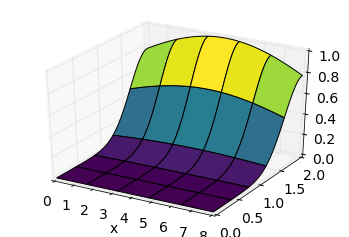

In [340]:
pi = init_cond(ny,nx,Lx,Ly,X,Y)
fig = pyplot.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(X,Y,pi,rstride=10,cstride=10,cmap=cm.viridis)
ax.set_xlim(0,8)
ax.set_ylim(0,2)
ax.set_xlabel('x');

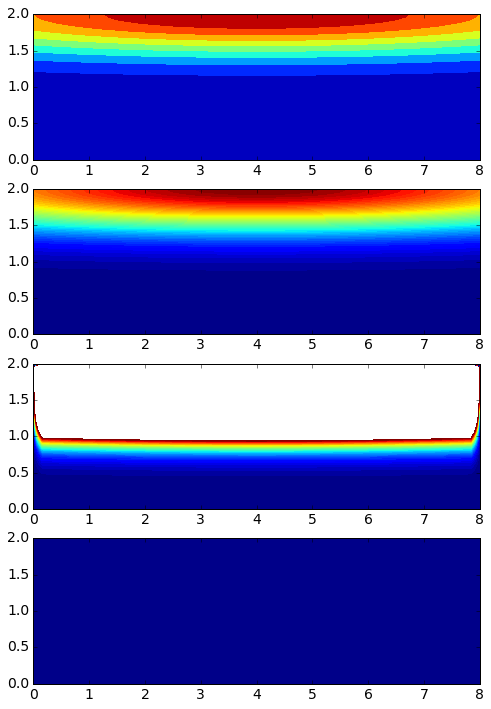

In [399]:
fig = pyplot.figure(figsize=(8,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
ax1.contourf(X,Y,f,levels=numpy.linspace(0,1,10))
ax2.contourf(X,Y,p[0],levels=numpy.linspace(0,1,50))
ax3.contourf(X,Y,p[1],levels=numpy.linspace(0,1,50))
ax4.contourf(X,Y,p[2],levels=numpy.linspace(0,1,50));

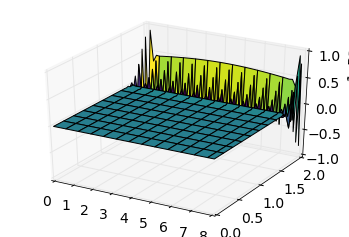

In [412]:
fig = pyplot.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(X,Y,p[31],rstride=5,cstride=4,cmap=cm.viridis)

In [331]:
numpy.shape(f)

(50, 50)

In [401]:
p[1,-2,:]

array([  0.        ,  25.89375997,  26.39528009,  26.88455885,
        27.36056346,  27.8222752 ,  28.26869302,  28.69883717,
        29.11175269,  29.50651302,  29.88222335,  30.23802408,
        30.57309406,  30.88665371,  31.17796808,  31.44634972,
        31.69116135,  31.91181839,  32.10779132,  32.27860774,
        32.42385432,  32.54317843,  32.63628959,  32.70296062,
        32.74302859,  32.75639549,  32.74302859,  32.70296062,
        32.63628959,  32.54317843,  32.42385432,  32.27860774,
        32.10779132,  31.91181839,  31.69116135,  31.44634972,
        31.17796808,  30.88665371,  30.57309406,  30.23802408,
        29.88222335,  29.50651302,  29.11175269,  28.69883717,
        28.26869302,  27.8222752 ,  27.36056346,  26.88455885,
        26.39528009,  25.89375997,   0.        ])